In [1]:
#Own modules
import Pixel_Raster_class as prc
import Classification_Function as cl
import Polygons_From_Groups_Function as pol

#External modules
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

### Classification

In [2]:
# Load raster file & Initialize output filepaths
filepath = "Data/Khartoum.tif"
output_classification_path = "Data/Khartoum_Classified.tif"
output_grouping_path = "Data/Khartoum_Grouped.tif"
output_geojson_path = "THE_CREATED_POLYGONS/Khartoum_Polygon.geojson"

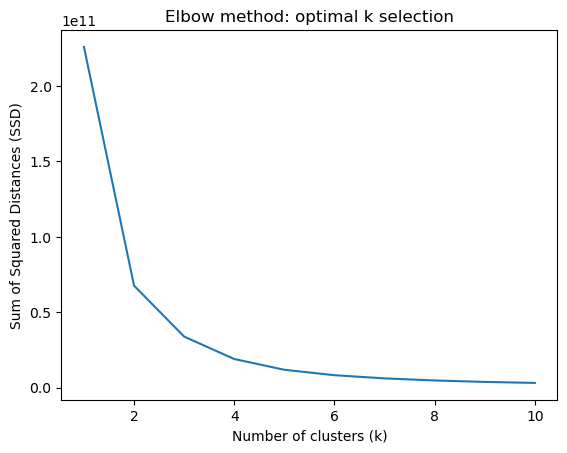

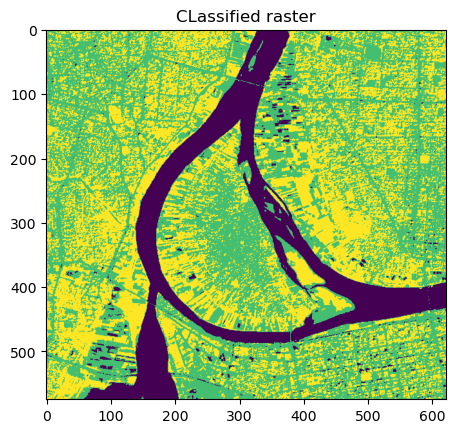

Classified raster saved.
Optimal k: 3


In [3]:
# Classify the raster using the set developed module. It can take a few minutes
max_k = 10
labels, centroids, optimal_k = cl.classify_single_band_raster(filepath, output_classification_path, max_k=max_k)
print("Optimal k:", optimal_k)

### Grouping process

In [4]:
# Read classified raster and create Pixel objects for all pixels of the band. This could take some seconds
with rasterio.open(output_classification_path) as src:
    band1 = src.read(1)
raster_lst = []
shape = band1.shape
for y, row in enumerate(band1):
    for x, elt in enumerate(row):
        pix = prc.Pixel(X=x, Y=y, Cluster_value=elt, Group=None)
        raster_lst.append(pix)

In [5]:
# Create raster object
Raster_object = prc.Raster(lst=raster_lst, shape=shape, groups=[], neighbours_diagonal=False) #If neighbours are also diagonal, this can be changed here

In [6]:
# Create groups for all clusters. It can take a few minutes
for centroid in centroids:
    print(centroid)
    Raster_object._grouping_process(centroid)
print(Raster_object.groups_per_cluster, Raster_object.n_groups, Raster_object.group_sizes[:1000])

3256.244423657665
3943.8592034510134
1654.6290059965847
{np.float64(3256.244423657665): (0, 3189), np.float64(3943.8592034510134): (3190, 8496), np.float64(1654.6290059965847): (8497, 9220)} 9221 [45643, 31, 2, 1, 4, 2, 3, 4, 8, 1, 2, 1, 4, 12, 1, 22, 7, 41, 13, 5, 2, 1, 31, 20, 6, 160, 2, 21, 38, 1, 107, 1, 2, 42808, 263, 13, 1, 16, 2, 2, 1, 1, 1, 2, 1, 11, 1, 3, 1, 7, 2, 2, 2, 3, 7, 3, 2, 1, 8, 1, 1, 1, 1, 8, 3, 5, 3, 1, 1, 3, 5, 9, 1, 1, 12, 1, 1, 1, 2, 1, 41, 2, 7, 1, 1, 13, 1, 1, 3, 1, 1, 1, 1, 1, 18, 5, 1, 1, 1, 5, 8, 1, 2, 2, 2, 2, 4, 3, 17, 1, 7, 7, 13, 2, 1, 4, 2, 1, 1, 10, 4, 1, 3, 1, 5, 44, 19, 20, 1, 31, 4, 1, 1, 1, 13, 4, 4, 1, 1, 6, 15, 1, 2, 14, 1, 1, 5, 2, 2, 2, 1, 8, 13, 1, 2, 1, 1, 5, 30, 2, 1, 5, 2, 36, 1, 1, 4, 1, 1, 14, 12, 7, 1, 2, 2, 6, 1, 2, 5, 9, 22, 42, 4, 5, 13, 4, 8, 2, 1, 6, 3, 2, 1, 22, 1, 1, 3, 1, 10, 3, 1, 2, 1, 38, 2, 1, 4, 2, 4, 2, 3, 2, 2, 16, 6, 1, 3, 3, 1, 7, 2, 38, 1, 16, 1, 2, 1, 5, 1, 1, 1, 1, 24, 1, 1, 1, 1, 1, 7, 5, 1, 1, 1, 8, 1, 87, 4, 5, 1, 

In [7]:
# Check if all pixels are assigned to a group. If it prints nothing, it has been done correctly
for pixel in Raster_object.lst:
    if pixel.group is None:
        print(pixel)

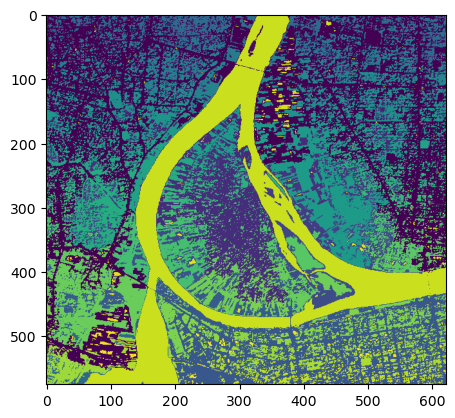

In [8]:
# Plot raster with different groups
Raster_object._output_raster(output_path=output_grouping_path, CRS=src.crs)
with rasterio.open(output_grouping_path) as Raster_grouped:
    band = Raster_grouped.read(1)
plt.imshow(band)
plt.show()

### Polygon creation

The polygon creation has only been done for the largest group. The group number can be changed.

In [9]:
TARGET_GROUP = np.argmax(Raster_object.group_sizes) #Change to desired group

In [10]:
# Create the polygon. This step might take up to a few minutes, depending on the size of the chosen group
polygon, polygon_size = pol.raster_group_to_polygon(output_grouping_path, TARGET_GROUP)
print("Polygon created")

Polygon created


<Figure size 623.077x576.923 with 0 Axes>

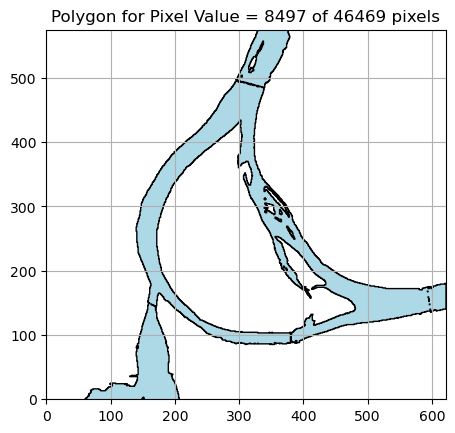

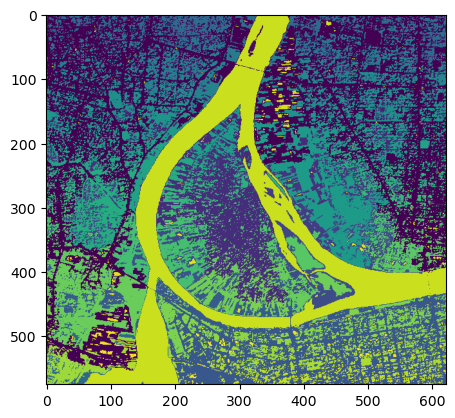

In [11]:
# Plot the polygon

# Get raster length and width
with rasterio.open(output_grouping_path) as src:
    data = src.read(1)
    y_length, x_length = src.shape

plt.figure(figsize=(12*x_length/(x_length+y_length), 12*y_length/(x_length+y_length))) # Set figure size based on raster shape

gdf = gpd.GeoDataFrame(geometry=[polygon])
gdf.plot(edgecolor="black", facecolor="lightblue")
plt.title(f"Polygon for Pixel Value = {TARGET_GROUP} of {polygon_size} pixels")
plt.axis([0, x_length, 0, y_length])
plt.grid(True)
plt.show()

plt.imshow(data)
plt.show()

In [12]:
# Save the polygon as GeoJSON
pol.save_polygon_geojson(polygon, output_geojson_path, TARGET_GROUP)

GeoJSON saved
